<a href="https://colab.research.google.com/github/IzmailovRuslan/super-duper-giggle/blob/main/Dense_and_Convoluation_NN_(MNIST)_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Полносвязные и свёрточные нейронные сети</b></h3>









In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

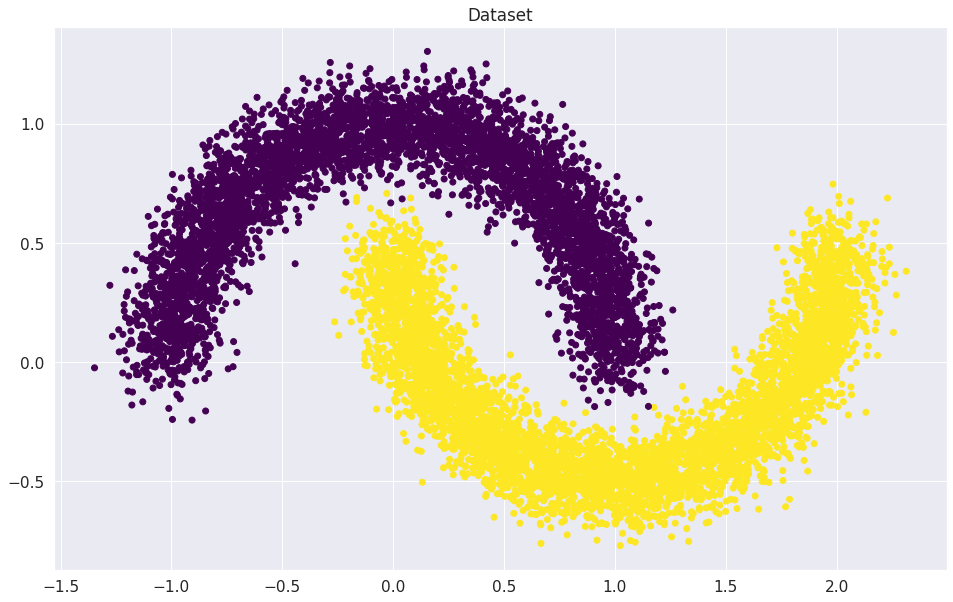

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

In [ ]:
X_train_t =  torch.Tensor(X_train)
y_train_t =  torch.Tensor(y_train)
X_val_t = torch.Tensor(X_val)
y_val_t =  torch.Tensor(y_val)

Создаем `Dataset` и `DataLoader`. 

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
На входе матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход называют "логитами" (logits). Необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу. Чаще всего в качестве функции берут сигмоиду 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Реализация логистической регрессии

Напишем модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear`. Инициализация весов производится нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features), requires_grad = True)
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features), requires_grad = True)

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [ ]:
list(linear_regression.parameters())

[Parameter containing:
 tensor([[0.9413],
         [1.8074]], requires_grad=True), Parameter containing:
 tensor([2.8604], requires_grad=True)]

Имеем 3 обучаемых параметра

### Train loop


```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):# итерируемся по эпохам
    for it, (X_batch, y_batch) in enumerate(train_dataloader): # в каждой эпохе рассматриваем наборы батчей
        optimizer.zero_grad() # обуляем градиенты модели
        outp = linear_regression.forward(X_batch).flatten() # получаем "логиты" из модели
        loss = loss_function(outp, y_batch) # считаем "лосс" для логистической регрессии
        loss.backward() #считаем градиенты
        losses.append(loss.detach().flatten()[0])
        optimizer.step() # делаем шаг градиентного спуска
        probabilities = torch.sigmoid(outp) # переводим "логиты" в вероятности классов
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.40625
Iteration: 100
Batch accuracy: 0.8125
Iteration: 200
Batch accuracy: 0.8515625
Iteration: 300
Batch accuracy: 0.90625
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.875
Iteration: 700
Batch accuracy: 0.8359375

Iteration: 755.Convergence. Stopping iterations.


Потребовалось примерно 750 итераций, чтобы алгоритм сошелся

### Визуализируем результаты

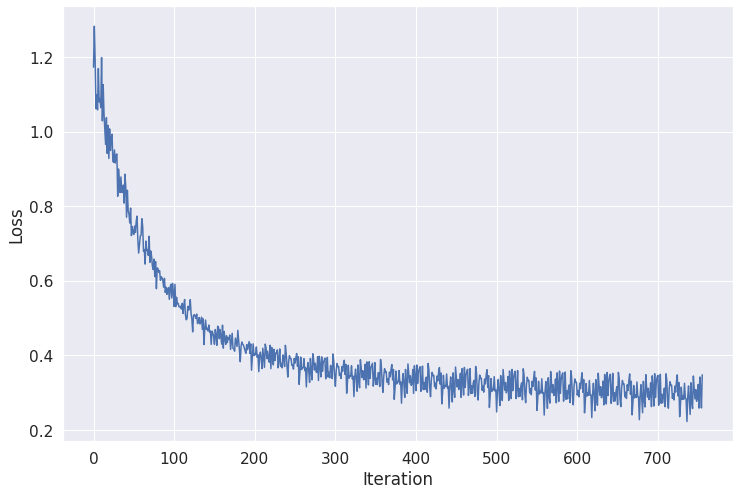

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

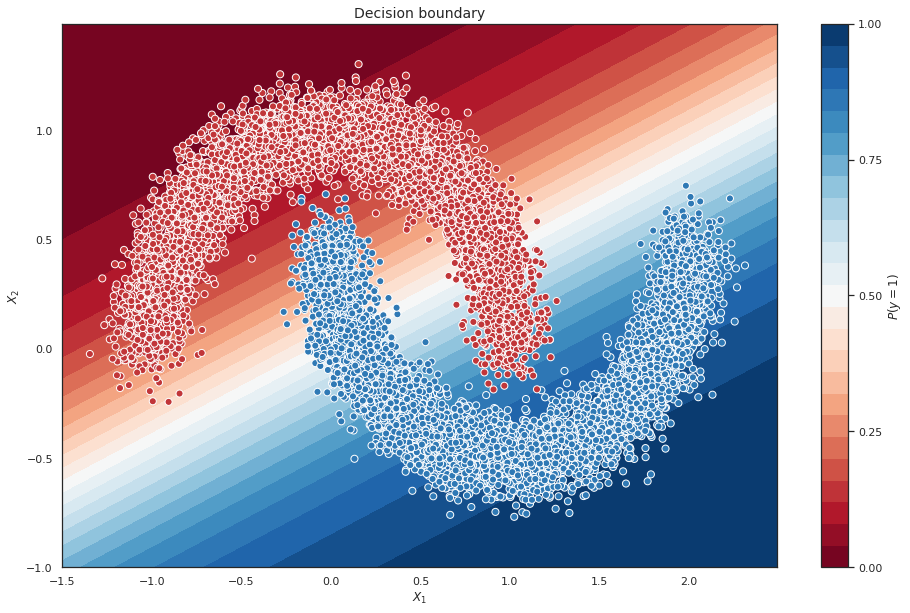

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Реализуем predict и посчитаем accuracy на test.

In [ ]:
@torch.no_grad() # Отключение вычисления градиента уменьшит потребление памяти для вычислений, которые в противном случае требовали бы require_grad=True
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        logits = model.forward(x_batch)
        preds = torch.sigmoid(logits).round()
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(predict(val_dataloader, linear_regression), y_val_t)

0.8688

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [ ]:
import os
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline
from torchvision.datasets import MNIST

In [ ]:
root = './'

transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

train_dataloader =  trainloader
valid_dataloader =  testloader

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Простая полносвязная нейронная сеть 

Создадим полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.


In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ELU(),
    nn.Linear(128, 128),
    nn.ELU(),
    nn.Linear(128, 128),
    nn.ELU(),
    nn.Linear(128, 10)
)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)



```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Цикл обучения.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}

correct = 0
all = 0

for epoch in range(max_epochs): # итерируемся по эпохам
    for k, dataloader in loaders.items(): 
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader: # в каждой эпохе рассматриваем наборы батчей
            if k == "train":
                model.train() # переводим модель в режим train 
                optimizer.zero_grad() # обуляем градиенты модели
                outp = model(x_batch) # получаем выходы из модели
                loss = criterion(outp, y_batch) # считаем "лосс" 
                loss.backward()  # считаем градиенты
                optimizer.step() # делаем шаг градиентного спуска
            else:
                model.eval() # переводим модель в режим test
                with torch.no_grad(): # НЕ считаем градиенты
                    outp = model(x_batch) # получаем выходы из модели

            preds = outp.argmax(-1) # в каждой строке находим максимум - тот класс, который предсказала модель 
            correct = sum(y_batch == preds) # сравниваем предсказания с правильными ответами 
            all =  len(y_batch)
            epoch_correct += correct
            epoch_all += all
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9053500294685364
Loader: valid. Accuracy: 0.9465000033378601
Epoch: 2
Loader: train. Accuracy: 0.9576166868209839
Loader: valid. Accuracy: 0.9603000283241272
Epoch: 3
Loader: train. Accuracy: 0.968416690826416
Loader: valid. Accuracy: 0.9671000242233276
Epoch: 4
Loader: train. Accuracy: 0.9759666919708252
Loader: valid. Accuracy: 0.9728000164031982
Epoch: 5
Loader: train. Accuracy: 0.9797333478927612
Loader: valid. Accuracy: 0.972100019454956
Epoch: 6
Loader: train. Accuracy: 0.984083354473114
Loader: valid. Accuracy: 0.9761999845504761
Epoch: 7
Loader: train. Accuracy: 0.9857500195503235
Loader: valid. Accuracy: 0.9750000238418579
Epoch: 8
Loader: train. Accuracy: 0.9881666898727417
Loader: valid. Accuracy: 0.9765999913215637
Epoch: 9
Loader: train. Accuracy: 0.989549994468689
Loader: valid. Accuracy: 0.9790999889373779
Epoch: 10
Loader: train. Accuracy: 0.9905833601951599
Loader: valid. Accuracy: 0.9807999730110168


### Протестируем разные функции активации.
Реализуем это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
elu_accuracy = accuracy["valid"]

In [ ]:
def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
        )

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    accuracy = {"train": [], "valid": []}

    correct = 0
    all = 0

    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()  
                    optimizer.zero_grad()  
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch) 
                    loss.backward()  
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad(): 
                        outp = model(x_batch) 

                preds = outp.argmax(-1)
                correct = sum(y_batch == preds)
                all =  len(y_batch)
                epoch_correct += correct.item()
                epoch_all += all
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]

In [ ]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)
sigmoid_accuracy = test_activation_function(nn.Sigmoid)
tanh_accuracy = test_activation_function(nn.Tanh)

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

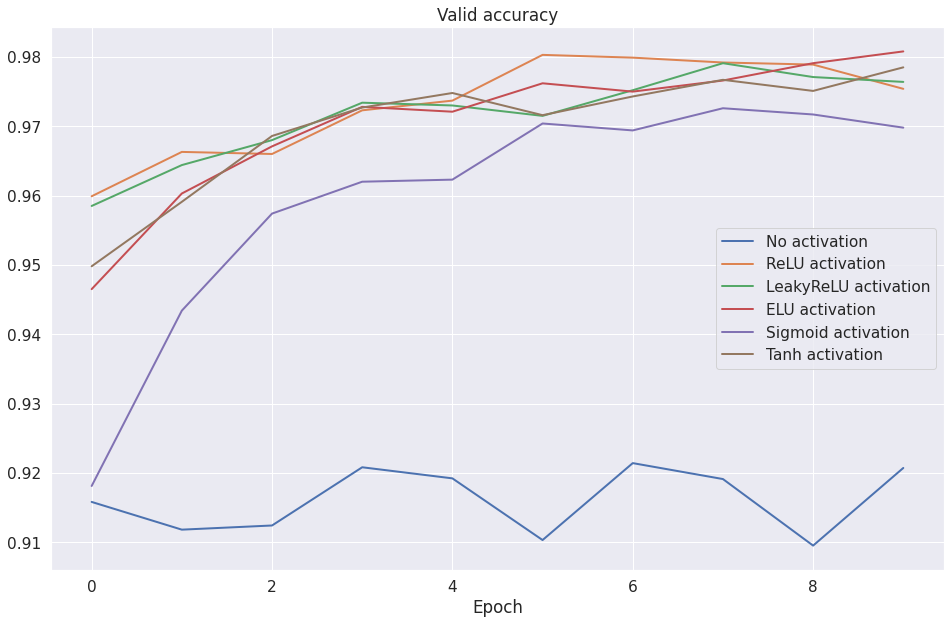

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), sigmoid_accuracy, label="Sigmoid activation", linewidth=2)
plt.plot(range(max_epochs), tanh_accuracy, label="Tanh activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

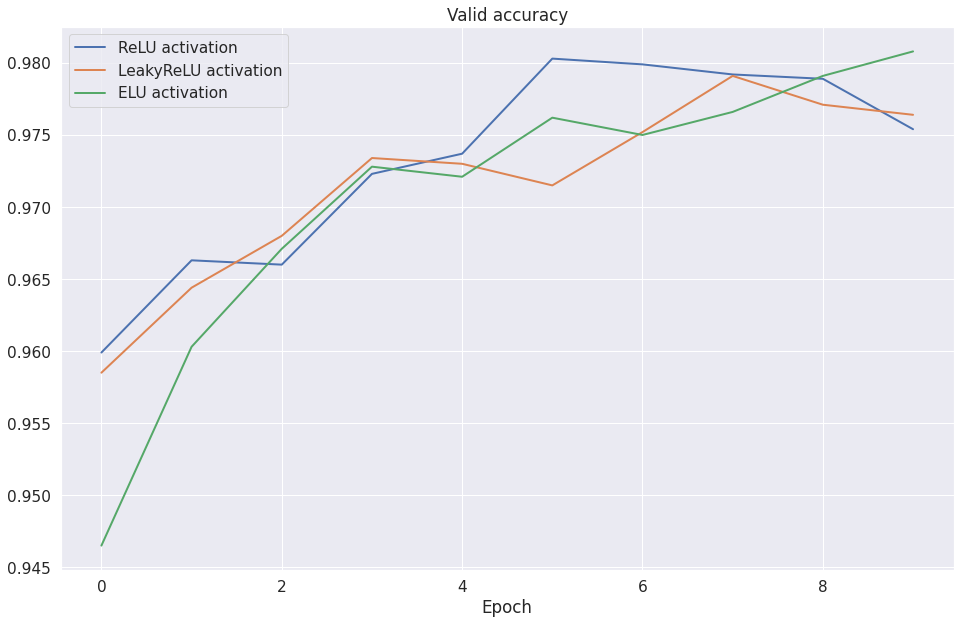

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

В данном случае ELU показала лучший результат к концу обучения, хотя по сути в этом примере все три функции работают примерно одинаково

## Часть 2.2 Сверточные нейронные сети

### Реализуем LeNet

Реализуем архитектуру LeNet, предложенную еще в 1998 году!
Используем модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.fc1 = nn.Linear(400, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 400) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Обучение CNN

In [ ]:
accuracy = {"train": [], "valid": []}

correct = 0
all = 0

for epoch in range(10):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()  
                optimizer.zero_grad()  
                outp = model(x_batch)
                loss = criterion(outp, y_batch) 
                loss.backward()  
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad(): 
                    outp = model(x_batch)

            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8941166666666667
Loader: valid. Accuracy: 0.9662
Epoch: 2
Loader: train. Accuracy: 0.9715666666666667
Loader: valid. Accuracy: 0.9822
Epoch: 3
Loader: train. Accuracy: 0.9799833333333333
Loader: valid. Accuracy: 0.9806
Epoch: 4
Loader: train. Accuracy: 0.98395
Loader: valid. Accuracy: 0.9841
Epoch: 5
Loader: train. Accuracy: 0.9862166666666666
Loader: valid. Accuracy: 0.9806
Epoch: 6
Loader: train. Accuracy: 0.98845
Loader: valid. Accuracy: 0.9873
Epoch: 7
Loader: train. Accuracy: 0.99
Loader: valid. Accuracy: 0.9882
Epoch: 8
Loader: train. Accuracy: 0.99125
Loader: valid. Accuracy: 0.9856
Epoch: 9
Loader: train. Accuracy: 0.9928833333333333
Loader: valid. Accuracy: 0.9871
Epoch: 10
Loader: train. Accuracy: 0.9932333333333333
Loader: valid. Accuracy: 0.9851


In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

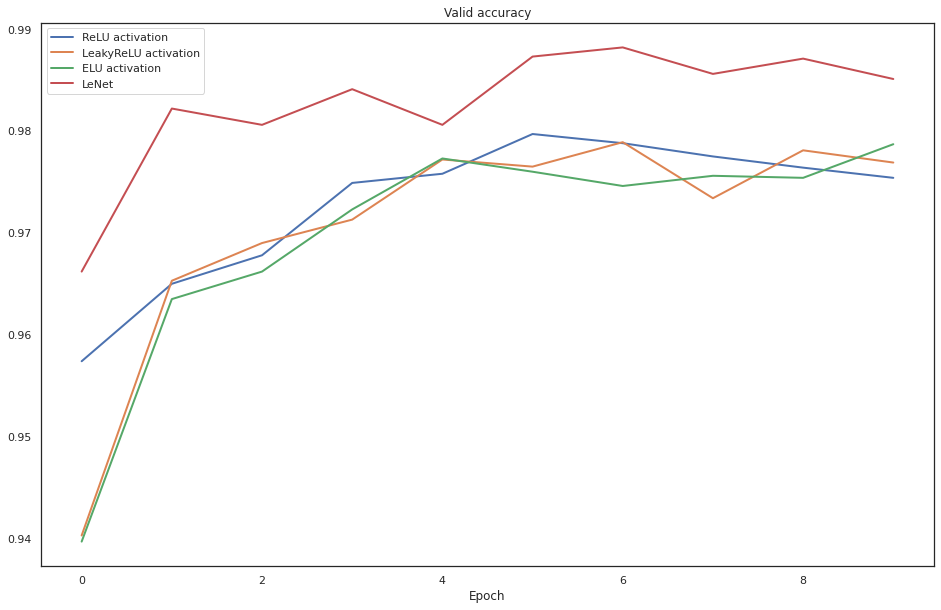

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
lenet_accuracy[-1]

0.9851

Ожидаемо, LeNet решает эту задачу лучше

